In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report

/Users/tatenda/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
metadata=pd.read_csv("movie_metadata_with_score_metacritic.csv", index_col="Unnamed: 0") #reading in metacritic dataset
metadata=metadata.loc[~metadata["metacritic_metascore"].isna()] #removing rows with no metacritic data
metadata=metadata.drop(["homepage","keywords","overview","status","tagline","imdb_metascore","budget","revenue"],1) #dropping unnecessary features
metadata=metadata.drop_duplicates() #dropping duplicates
metadata["release_year"]=metadata.release_date.str[0:4].astype(int) #creating new column with year for comparison


In [3]:
num_data=pd.read_csv("the_numbers_budget.csv") #reading in revenue data
num_data=num_data.rename(columns={"Movie":"title"}) #renaming column to match metadata
num_data["num_year"]=num_data["Release Date"].str[-4:].astype(int)
num_data=num_data.drop_duplicates()#dropping duplicates

In [4]:
critic_revenue=metadata.merge(num_data,on="title") #merging datasets
critic_revenue=critic_revenue.drop_duplicates() #dropping duplicates
critic_revenue=critic_revenue.loc[(critic_revenue["Worldwide Gross"]!=0)] #removing rows with no revenue data
critic_revenue=critic_revenue.loc[(np.abs(critic_revenue.release_year-critic_revenue.num_year)<5)] #removing rows where the years don't match, as this indicates different movies

critic_revenue["log Worldwide Gross"]=np.log(critic_revenue["Worldwide Gross"])#adding column for log of revenue

In [7]:
critic_revenue_small=critic_revenue.loc[critic_revenue['Production Budget'] <= 40000000]
critic_revenue_small.shape[0]

2379

In [8]:
#Normalizing by the median for merged data set

critic_revenue_small["Production Budget"]=(critic_revenue_small["Production Budget"]-critic_revenue_small["Production Budget"].median())/critic_revenue_small["Production Budget"].std()
critic_revenue_small["Worldwide Gross"]=(critic_revenue_small["Worldwide Gross"]-critic_revenue_small["Worldwide Gross"].median())/critic_revenue_small["Worldwide Gross"].std()
critic_revenue_small["log Worldwide Gross"]=(critic_revenue_small["log Worldwide Gross"]-critic_revenue_small["log Worldwide Gross"].median())/critic_revenue_small["log Worldwide Gross"].std()
critic_revenue_small["Domestic Gross"]=(critic_revenue_small["Domestic Gross"]-critic_revenue_small["Domestic Gross"].median())/critic_revenue_small["Domestic Gross"].std()
critic_revenue_small["popularity"]=(critic_revenue_small["popularity"]-critic_revenue_small["popularity"].median())/critic_revenue_small["popularity"].std()
critic_revenue_small["vote_count"]=(critic_revenue_small["vote_count"]-critic_revenue_small["vote_count"].median())/critic_revenue_small["vote_count"].std()
critic_revenue_small["metacritic_metascore"]=(critic_revenue_small["metacritic_metascore"]-critic_revenue_small["metacritic_metascore"].median())/critic_revenue_small["metacritic_metascore"].std()
critic_revenue_small["runtime"]=(critic_revenue_small["runtime"]-critic_revenue_small["runtime"].median())/critic_revenue_small["runtime"].std()

# Reindex since the dataset has been subset many times
critic_revenue_small.index=range(len(critic_revenue_small))

/Users/tatenda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/tatenda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/tatenda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [9]:
critic_revenue_small

,genres,id,original_language,original_title,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,...,vote_average,vote_count,metacritic_metascore,release_year,Release Date,Production Budget,Domestic Gross,Worldwide Gross,num_year,log Worldwide Gross
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",79698,en,The Lovers,-0.559237,"[{""name"": ""Corsan"", ""id"": 7299}, {""name"": ""Bli...","[{""iso_3166_1"": ""AU"", ""name"": ""Australia""}, {""...",2015-02-13,0.369633,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",...,4.8,-0.238204,-1.896911,2015,3/13/2015,1.783537,-0.412489,-0.324116,2015,-3.400324
1,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",9799,en,The Fast and the Furious,-0.312578,"[{""name"": ""Universal Pictures"", ""id"": 33}, {""n...","[{""iso_3166_1"": ""DE"", ""name"": ""Germany""}, {""is...",2001-06-22,0.211219,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",...,6.6,4.016870,0.158076,2001,6/22/2001,2.038328,3.360258,2.543951,2001,0.968828
2,"[{""id"": 80, ""name"": ""Crime""}, {""id"": 18, ""name...",29193,en,The Spanish Prisoner,-0.522303,"[{""name"": ""Jean Doumanian Productions"", ""id"": ...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1997-09-08,0.422438,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",...,7.1,-0.189309,0.790380,1997,4/3/1998,-0.339721,-0.147191,-0.132116,1998,-0.232567
3,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",9387,en,Conan the Barbarian,1.054487,"[{""name"": ""Universal Pictures"", ""id"": 33}, {""n...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1982-04-02,1.425728,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",...,6.6,0.534078,-0.632304,1982,5/14/1982,0.509582,0.586462,0.774535,1982,0.542399
4,"[{""id"": 27, ""name"": ""Horror""}, {""id"": 35, ""nam...",16281,en,Creepshow,0.058192,"[{""name"": ""Warner Bros."", ""id"": 6194}, {""name""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1982-11-12,0.950485,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",...,6.7,0.002507,0.210768,1982,11/10/1982,-0.509582,0.110593,-0.045989,1982,-0.067976
5,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10751, ""...",15189,en,Hotel for Dogs,0.036018,"[{""name"": ""DreamWorks SKG"", ""id"": 27}, {""name""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-01-16,-0.105609,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",...,5.7,-0.027582,-0.210768,2009,1/16/2009,1.783537,1.497965,1.375132,2009,0.736200
6,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""n...",802,en,Lolita,0.623892,"[{""name"": ""Seven Arts Productions"", ""id"": 516}...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",1962-06-13,2.693042,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",...,7.3,0.214383,-0.474228,1962,1/1/1962,-1.019164,-0.171001,-0.195798,1962,-0.411494
7,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",1368,en,First Blood,2.771674,"[{""name"": ""Orion Pictures"", ""id"": 41}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1982-10-22,-0.475243,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",...,7.2,1.584683,0.316152,1982,10/22/1982,0.000000,0.820087,1.414795,1982,0.746454
8,"[{""id"": 27, ""name"": ""Horror""}, {""id"": 9648, ""n...",768,en,From Hell,0.743205,"[{""name"": ""Twentieth Century Fox Film Corporat...","[{""iso_3166_1"": ""CZ"", ""name"": ""Czech Republic""...",2001-10-19,1.056095,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",...,6.6,0.648165,-0.052692,2001,10/19/2001,1.783537,0.412440,0.630067,2001,0.479750
9,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 10751...",10895,en,Pinocchio,1.834606,"[{""name"": ""RKO Radio Pictures"", ""id"": 6}, {""na...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1940-02-23,-0.739266,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",...,6.9,1.417940,-2.318447,1940,2/9/1940,-0.994598,1.788310,0.846561,1940,0.570617


In [10]:
critic_revenue_small.head()

,genres,id,original_language,original_title,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,...,vote_average,vote_count,metacritic_metascore,release_year,Release Date,Production Budget,Domestic Gross,Worldwide Gross,num_year,log Worldwide Gross
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",79698,en,The Lovers,-0.559237,"[{""name"": ""Corsan"", ""id"": 7299}, {""name"": ""Bli...","[{""iso_3166_1"": ""AU"", ""name"": ""Australia""}, {""...",2015-02-13,0.369633,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",...,4.8,-0.238204,-1.896911,2015,3/13/2015,1.783537,-0.412489,-0.324116,2015,-3.400324
1,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",9799,en,The Fast and the Furious,-0.312578,"[{""name"": ""Universal Pictures"", ""id"": 33}, {""n...","[{""iso_3166_1"": ""DE"", ""name"": ""Germany""}, {""is...",2001-06-22,0.211219,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",...,6.6,4.016870,0.158076,2001,6/22/2001,2.038328,3.360258,2.543951,2001,0.968828
2,"[{""id"": 80, ""name"": ""Crime""}, {""id"": 18, ""name...",29193,en,The Spanish Prisoner,-0.522303,"[{""name"": ""Jean Doumanian Productions"", ""id"": ...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1997-09-08,0.422438,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",...,7.1,-0.189309,0.790380,1997,4/3/1998,-0.339721,-0.147191,-0.132116,1998,-0.232567
3,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",9387,en,Conan the Barbarian,1.054487,"[{""name"": ""Universal Pictures"", ""id"": 33}, {""n...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1982-04-02,1.425728,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",...,6.6,0.534078,-0.632304,1982,5/14/1982,0.509582,0.586462,0.774535,1982,0.542399
4,"[{""id"": 27, ""name"": ""Horror""}, {""id"": 35, ""nam...",16281,en,Creepshow,0.058192,"[{""name"": ""Warner Bros."", ""id"": 6194}, {""name""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1982-11-12,0.950485,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",...,6.7,0.002507,0.210768,1982,11/10/1982,-0.509582,0.110593,-0.045989,1982,-0.067976


In [11]:
critic_revenue_small.describe()

,id,popularity,runtime,vote_average,vote_count,metacritic_metascore,release_year,Production Budget,Domestic Gross,Worldwide Gross,num_year,log Worldwide Gross
count,2379.000000,2379.000000,2379.000000,2379.000000,2379.000000,2379.000000,2379.000000,2379.000000,2379.000000,2379.000000,2379.000000,2379.000000
mean,49247.907524,0.295320,0.183385,6.226776,0.354415,-0.000199,2002.621269,0.146551,0.344141,0.360866,2002.775116,-0.237051
std,79302.281613,1.000000,1.000000,0.940667,1.000000,1.000000,11.023024,1.000000,1.000000,1.000000,11.070055,1.000000
min,14.000000,-0.691788,-5.386083,0.000000,-0.280830,-2.845367,1934.000000,-1.188430,-0.412489,-0.324269,1934.000000,-6.092378
25%,8989.500000,-0.379955,-0.422438,5.700000,-0.194951,-0.737688,1999.000000,-0.764373,-0.331764,-0.244465,1999.000000,-0.623104
50%,13982.000000,0.000000,0.000000,6.300000,0.000000,0.000000,2005.000000,0.000000,0.000000,0.000000,2005.000000,0.000000
75%,46716.000000,0.657678,0.607255,6.850000,0.454468,0.737688,2010.000000,0.934234,0.618591,0.541198,2010.000000,0.436306
max,385736.000000,9.881232,12.461919,9.300000,10.285393,2.371139,2016.000000,2.208189,9.267449,9.020244,2017.000000,1.493758


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LogisticRegression # to apply the Logistic regression
from sklearn.model_selection import train_test_split # to split the data into two parts

In [13]:
%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

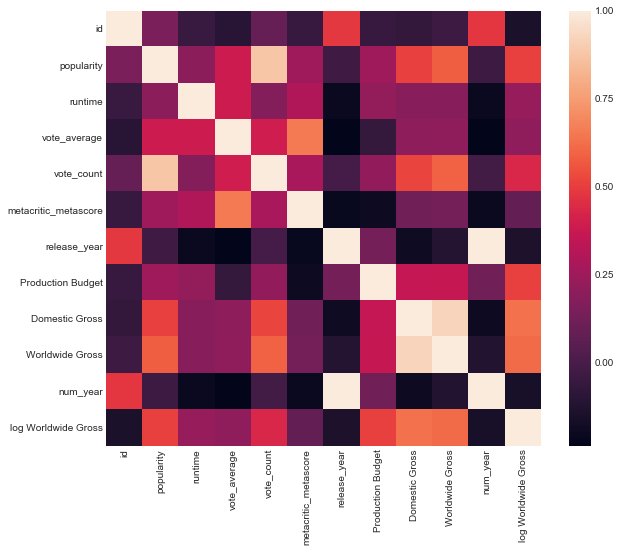

In [14]:
sns.heatmap(critic_revenue_small.corr(), vmax=1, square=True)

In [15]:
#Defining features and target for this dataset based on co-relation
features = ['Production Budget']
target = ['Worldwide Gross']

In [16]:
#splitting data set into training and test data set in 0.7/0.3
train, test = train_test_split(critic_revenue_small,test_size=0.30)
train.head()

,genres,id,original_language,original_title,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,...,vote_average,vote_count,metacritic_metascore,release_year,Release Date,Production Budget,Domestic Gross,Worldwide Gross,num_year,log Worldwide Gross
299,"[{""id"": 53, ""name"": ""Thriller""}, {""id"": 878, ""...",45612,en,Source Code,2.559023,"[{""name"": ""The Mark Gordon Company"", ""id"": 155...","[{""iso_3166_1"": ""CA"", ""name"": ""Canada""}, {""iso...",2011-03-30,-0.475243,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",...,7.1,3.102919,1.001148,2011,4/1/2011,1.528746,1.015870,1.626122,2011,0.797424
2173,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 9648, ""n...",11219,en,The Trouble with Harry,-0.311978,"[{""name"": ""Paramount Pictures"", ""id"": 4}, {""na...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1955-10-03,-0.158414,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",...,6.9,-0.094028,1.001148,1955,10/3/1955,-1.087109,-0.229741,-0.227048,1955,-0.535366
1286,"[{""id"": 27, ""name"": ""Horror""}, {""id"": 53, ""nam...",578,en,Jaws,2.062205,"[{""name"": ""Universal Pictures"", ""id"": 33}, {""n...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1975-06-18,1.161704,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",...,7.5,2.906087,1.686143,1975,6/20/1975,-0.169861,6.375267,6.213218,1975,1.334987
619,"[{""id"": 18, ""name"": ""Drama""}]",200505,en,Draft Day,0.086134,"[{""name"": ""Summit Entertainment"", ""id"": 491}, ...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2014-04-11,0.369633,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",...,6.5,0.100296,-0.052692,2014,4/11/2014,0.934234,0.340488,0.090278,2014,0.109160
1957,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",14256,en,Winter Passing,-0.491959,"[{""name"": ""Yari Film Group"", ""id"": 2448}, {""na...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2006-02-07,-0.211219,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",...,6.7,-0.245726,0.052692,2006,2/17/2006,-0.891769,-0.409682,-0.322689,2006,-2.366191


In [17]:
#Fill the training and test data with require information
X_train = train[features].dropna()
y_train = train[target].dropna()
X_test = test[features].dropna()
y_test = test[target].dropna()

In [18]:
from sklearn import linear_model# compute classification accuracy for the linear regression model
from sklearn import metrics # for the check the error and accuracy of the model
lin = linear_model.LinearRegression()
# train the model on the training set
lin.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [19]:
lin_score_train = lin.score(X_test, y_test)
lin_score_test = lin.score(X_train, y_train)

In [20]:
print("Training score: ",lin_score_train)
print("Testing score: ",lin_score_test)

Training score:  0.14815187276494057
Testing score:  0.1282860117037905


In [21]:
yPrediction = lin.predict(X_test)


In [22]:
#Calculate root-mean-square error (RMSE):
import numpy as np
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(yPrediction, y_test)
lin_rmse = np.sqrt(lin_mse)
print('Linear Regression RMSE: %.4f' % lin_rmse)

Linear Regression RMSE: 0.8973


In [23]:
#Calculate mean absolute error (MAE):
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(yPrediction, y_test)
print('Liner Regression MAE: %.4f' % lin_mae)

Liner Regression MAE: 0.5651


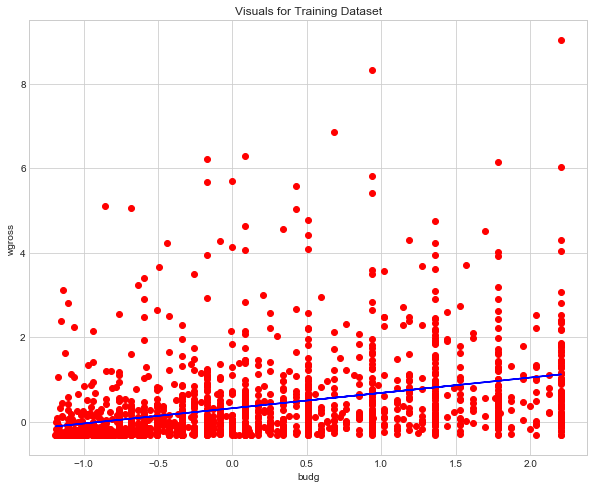

In [24]:
# Visualising the training set results
plt.scatter(X_train, y_train, color = 'red')
plt.plot(X_train, lin.predict(X_train), color = 'blue')
plt.title ("Visuals for Training Dataset")
plt.xlabel("budg")
plt.ylabel("wgross")
plt.show()

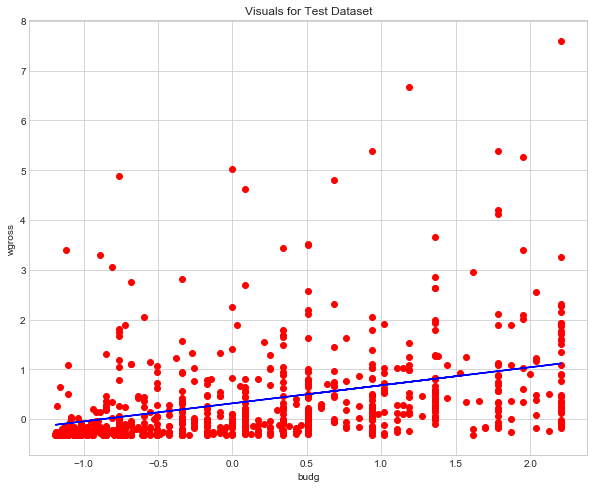

In [25]:
plt.scatter(X_test, y_test , color = 'red')
plt.plot(X_train, lin.predict(X_train), color = 'blue')
plt.title ("Visuals for Test Dataset")
plt.xlabel("budg")
plt.ylabel("wgross")
plt.show()

In [26]:
from sklearn import neighbors
n_neighbors=5
knn=neighbors.KNeighborsRegressor(n_neighbors,weights='uniform')
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [27]:
knn_score_train = knn.score(X_test, y_test)
knn_score_test = knn.score(X_train, y_train)

print("Training score: ",knn_score_train)
print("Testing score: ",knn_score_test)

Training score:  0.03978820591141219
Testing score:  0.07430899289821724
